In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join('..')))
sys.path.insert(0, os.path.abspath(os.path.join('../core')))
import numpy as np
import pickle
import numpy as np
from functools import partial
import tensorflow as tf

from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Lambda, Subtract, Dense
from keras.layers.merge import _Merge
from keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.datasets import mnist

import train
import costs
from data import predict_with_K_fn
from layer import stack_layers
from util import LearningHandler, make_layer_list, train_gen, get_scale

from sklearn.manifold import TSNE

%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
def predict_with_K_fn(K_fn, x, bs=1000):
    '''
    Convenience function: evaluates x by K_fn(x), where K_fn is
    a Keras function, by batches of size 1000.
    '''
    if not isinstance(x, list):
        x = [x]
    num_outs = len(K_fn.outputs)
    y = [np.empty((len(x[0]), output_.get_shape()[1])) for output_ in K_fn.outputs]
    recon_means = []
    for i in range(int((x[0].shape[0]-1)/bs + 1)):
        x_batch = []
        for x_ in x:
            x_batch.append(x_[i*bs:(i+1)*bs])
        temp = K_fn(x_batch)
        for j in range(num_outs):
            y[j][i*bs:(i+1)*bs] = temp[j]

    return y

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_context('paper')
from matplotlib.colors import ListedColormap
# cmap1 = ListedColormap(sns.color_palette().as_hex())
# cmap2 = ListedColormap(sns.color_palette('bright').as_hex())
def plot(x, y=None, x2=None, y2=None, s=10, alpha=0.5, label1=None, label2=None, cmap1=None, cmap2=None):
    n = x.shape[1]
    if n == 1:
        g = plt.figure()
        plt.scatter(np.zeros((n,)), x[:,1], c=y, s=s, alpha=alpha, label=label1, cmap=cmap1)
        if x2 is not None:
            plt.scatter(np.zeros((n,)), x2[:,1], c=y2, s=s, alpha=alpha, label=label2, cmap=cmap2)
    if n == 3:
        %matplotlib notebook
        g = plt.figure()
        ax = g.add_subplot(111, projection='3d')
        ax.scatter(x[:,0], x[:,1], x[:,2], c=y, s=s, alpha=alpha, label=label1)
        if x2 is not None:
            ax.scatter(x2[:,0], x2[:,1], x2[:,2], c=y2, s=s, alpha=alpha, label=label2)
    elif n == 784:
        %matplotlib inline
        n_imgs = 10
        # num = 7
        # sub = y == num
        sub = y == y
        for i in range(n_imgs):
            idx = np.random.randint(len(x[sub]))
            if x2 is not None:
                plt.subplot(1,2,1)
                plt.imshow(x2[sub][idx].reshape(28, 28))
            plt.subplot(1,2,2)
            plt.imshow(x[sub][idx].reshape(28, 28))
            g = plt.figure()
    else:
        g = plt.figure()
        plt.scatter(x[:,0], x[:,1], c=y, s=s, alpha=alpha, label=label1, cmap=cmap1)
        if x2 is not None:
            plt.scatter(x2[:,0], x2[:,1], c=y2, s=s, alpha=alpha, label=label2, cmap=cmap2)
            
    if label1 is not None or label2 is not None:
        plt.legend()
        
    return g

In [4]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# def plot(x, y=None, x2=None, y2=None, s=20, alpha=0.5):
#     if len(x.shape) < 2:
#         x = np.expand_dims(x, axis=-1)
#     d = x.shape[1]
#     n = x.shape[0]
    
#     # create dummy labels if unlabeled
#     if y is None:
#         y = np.zeros(len(x))
#     if y2 is None:
#         y2 = np.ones(len(x2))
        
#     # concatenate to create single vector
#     if x2 is not None:
#             x = np.concatenate([x, x2], axis=0)
#             y = np.concatenate([y, y2], axis=0)
#             print('IMPORTANT', x.shape, y.shape)
    
#     if d == 1:
#         g = sns.scatterplot(np.zeros((n,)), x[:,0], hue=y, size=s, hue_norm=(0, np.max(y)), alpha=alpha)
#     elif d == 3:
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')
#         ax.scatter(x[:,0], x[:,1], x[:,2], c=y, marker='o')
#         if x2 is not None:
#             ax.scatter(x2[:,0], x2[:,1], x2[:,2], c=y2, s=10)
#     elif d == 784:
#         %matplotlib inline
#         n_imgs = 10
#         # num = 7
#         # sub = y == num
#         sub = y == y
#         for i in range(n_imgs):
#             idx = np.random.randint(len(x[sub]))
#             if x2 is not None:
#                 plt.subplot(1,2,1)
#                 plt.imshow(x2[sub][idx].reshape(28, 28))
#             plt.subplot(1,2,2)
#             plt.imshow(x[sub][idx].reshape(28, 28))
#             plt.figure()
#     else:
        
#         g = sns.scatterplot(x[:,0], x[:,1], hue=y, s=s, hue_norm=(0, np.max(y)), alpha=alpha)
        
# #     g._legend.texts[0].set_text('predicted')
# #     g._legend.texts[0].set_text('actual')
    
#     return g

In [5]:
def generate_loop(n=1200, train_set_fraction=.8):
    t = np.linspace(0, 2*np.pi, num=n)
    
    # generate all three coordinates
    x = np.empty((n, 3))
    x[:,0] = np.cos(t)
    x[:,1] = np.sin(2*t)
    x[:,2] = np.sin(3*t)
    
    # y is just t
    y = t
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_circle(n=1000, train_set_fraction=.8, alpha=4):
    t = np.linspace(0, 2*np.pi, num=n)
#     t = np.log(np.linspace(1, alpha, num=n))
    t = t / np.max(t) * 2 * np.pi
    
    # generate all three coordinates
    x = np.empty((n, 2))
    x[:,0] = np.cos(t)
    x[:,1] = np.sin(t)
    
    # y is just t
    y = t
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_line(n=1200, train_set_fraction=.8):
    pts_per_cluster = int(n / 2)
    x1 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x2 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x = np.concatenate([x1, x2], axis=1)
    
    # generate labels
#     y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)
    y = x1
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_gaussians(n=1200, n_clusters=2, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / n_clusters)
    r = 1
    
    clusters = []
    
    for x in np.linspace(0, 1, num=n_clusters):
        clusters.append(np.random.normal(x, noise_sigma, size=(pts_per_cluster, 2)))

    # combine clusters
    x = np.concatenate(clusters, axis=0)
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_cc(n=1200, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / 2)
    r = 1

    # generate clusters
    theta1 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)
    theta2 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)

    cluster1 = np.concatenate((np.cos(theta1) * r, np.sin(theta1) * r), axis=1)
    cluster2 = np.concatenate((np.cos(theta2) * r, np.sin(theta2) * r), axis=1)

    # shift and reverse cluster 2
    cluster2[:, 0] = -cluster2[:, 0] + 0.5
    cluster2[:, 1] = -cluster2[:, 1] - 1

    # combine clusters
    x = np.concatenate((cluster1, cluster2), axis=0)

    # add noise to x
    x = x + np.random.randn(x.shape[0], 2) * noise_sigma
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

In [6]:
dataset = 'loop'

if dataset == 'mnist':
#     (x_train, y_train), (x_test, y_test) = mnist.load_data()
#     x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # reshape and standardize x arrays
    x_train = x_train.reshape(len(x_train), -1) / 255
    x_test = x_test.reshape(len(x_test), -1) / 255
    latent_dim = 10
elif dataset == 'gaussians':
    (x_train, y_train), (x_test, y_test) = generate_gaussians(n=2000, n_clusters=1, train_set_fraction=0.85)
    latent_dim = 6
elif dataset == 'line':
    (x_train, y_train), (x_test, y_test) = generate_line(n=2000, train_set_fraction=0.85)
    latent_dim = 2
elif dataset == 'loop':
    (x_train, y_train), (x_test, y_test) = generate_loop(n=1000, train_set_fraction=0.85)
    latent_dim = 3
elif dataset == 'cc':
    (x_train, y_train), (x_test, y_test) = generate_cc(n=2000, noise_sigma=0.1, train_set_fraction=0.85)
    latent_dim = 3
elif dataset == 'circle':
    (x_train, y_train), (x_test, y_test) = generate_circle(n=1024, train_set_fraction=0.85, alpha=30)
    latent_dim = 3

x_all = np.concatenate([x_train, x_test], axis=0)
    
# normalize to between -1 and 1
if dataset != 'mnist':
    m, M = np.min(x_train), np.max(x_train)
    a = (M + m) / 2
    b = (M - m) / 2
    x_train, x_test = (x_train - a) / b, (x_test - a) / b
print('IMPORTANT: max {}, min {}'.format(np.max(x_train), np.min(x_train)))

arch = [
    {'type': 'relu', 'size': 128},
    {'type': 'relu', 'size': 128},
    {'type': 'relu', 'size': 512},
    {'type': 'linear', 'size': 16},
    ]

IMPORTANT: max 1.0, min -1.0


In [7]:
class SpectralNet:
    def __init__(self, inputs, arch, spec_reg, y_true, y_train_labeled_onehot,
            n_clusters, affinity, scale_nbr, n_nbrs, batch_sizes, normalized=False,
            siamese_net=None, x_train=None, have_labeled=False):
        self.y_true = y_true
        self.y_train_labeled_onehot = y_train_labeled_onehot
        self.inputs = inputs
        self.batch_sizes = batch_sizes
        self.normalized = normalized
        # generate layers
        self.layers = make_layer_list(arch[:-1], 'spectral', spec_reg)
        self.layers += [
                  {'type': 'tanh',
                   'size': n_clusters,
                   'l2_reg': spec_reg,
                   'name': 'spectral_{}'.format(len(arch)-1)},
                  {'type': 'Orthonorm', 'name':'orthonorm'}
                  ]

        # create spectralnet
        self.outputs = stack_layers(self.inputs, self.layers)
        self.net = Model(inputs=self.inputs['Unlabeled'], outputs=self.outputs['Unlabeled'])

        # DEFINE LOSS

        # generate affinity matrix W according to params
        if affinity == 'siamese':
            input_affinity = tf.concat([siamese_net.outputs['A'], siamese_net.outputs['Labeled']], axis=0)
            x_affinity = siamese_net.predict(x_train, batch_sizes)
        elif affinity in ['knn', 'full']:
            input_affinity = tf.concat([self.inputs['Unlabeled'], self.inputs['Labeled']], axis=0)
            x_affinity = x_train

        # calculate scale for affinity matrix
        scale = get_scale(x_affinity, self.batch_sizes['Unlabeled'], scale_nbr)

        # create affinity matrix
        if affinity == 'full':
            W = costs.full_affinity(input_affinity, scale=scale)
        elif affinity in ['knn', 'siamese']:
            W = costs.knn_affinity(input_affinity, n_nbrs, scale=scale, scale_nbr=scale_nbr)

        # if we have labels, use them
        if have_labeled:
            # get true affinities (from labeled data)
            W_true = tf.cast(tf.equal(costs.squared_distance(y_true), 0),dtype='float32')

            # replace lower right corner of W with W_true
            unlabeled_end = tf.shape(self.inputs['Unlabeled'])[0]
            W_u = W[:unlabeled_end, :]                  # upper half
            W_ll = W[unlabeled_end:, :unlabeled_end]    # lower left
            W_l = tf.concat((W_ll, W_true), axis=1)      # lower half
            W = tf.concat((W_u, W_l), axis=0)

            # create pairwise batch distance matrix self.Dy
            y_ = tf.concat([self.outputs['Unlabeled'], self.outputs['Labeled']], axis=0)
        else:
            y_ = self.outputs['Unlabeled']
            
        if self.normalized:
            y_old = y_
            y_ = y_ / tf.expand_dims(tf.reduce_sum(W, axis=1), axis=-1)
        
        self.Dy = costs.squared_distance(y_)

        # define loss
        self.loss = K.sum(W * self.Dy) / (2 * batch_sizes['Unlabeled'])

        # create the train step update
        self.learning_rate = tf.Variable(0., name='spectral_net_learning_rate')
        self.train_step = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)
#         self.train_step = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)
        
        # initialize spectralnet variables
        K.get_session().run(tf.variables_initializer(self.net.trainable_weights))

    def train(self, x_train_unlabeled, x_train_labeled, x_val_unlabeled,
            lr, drop, patience, num_epochs):
        # create handler for early stopping and learning rate scheduling
        self.lh = LearningHandler(
                lr=lr,
                drop=drop,
                lr_tensor=self.learning_rate,
                patience=patience)

        losses = np.empty((num_epochs,))
        val_losses = np.empty((num_epochs,))

        # begin spectralnet training loop
        self.lh.on_train_begin()
        i = 0
        for i in range(num_epochs):
            # train spectralnet
            losses[i] = train.train_step(
                    return_var=[self.loss],
                    updates=self.net.updates + [self.train_step],
                    x_unlabeled=x_train_unlabeled,
                    inputs=self.inputs,
                    y_true=self.y_true,
                    batch_sizes=self.batch_sizes,
                    x_labeled=x_train_labeled,
                    y_labeled=self.y_train_labeled_onehot,
                    batches_per_epoch=100)[0]

            # get validation loss
            val_losses[i] = train.predict_sum(
                    self.loss,
                    x_unlabeled=x_val_unlabeled,
                    inputs=self.inputs,
                    y_true=self.y_true,
                    x_labeled=x_train_unlabeled[0:0],
                    y_labeled=self.y_train_labeled_onehot,
                    batch_sizes=self.batch_sizes)

            # do early stopping if necessary
            if self.lh.on_epoch_end(i, val_losses[i]):
                print('STOPPING EARLY')
                break

            # print training status
            print("Epoch: {}, loss={:2f}, val_loss={:2f}".format(i, losses[i], val_losses[i]))

        return losses[:i+1], val_losses[:i+1]
    
    def predict(self, x):
        # test inputs do not require the 'Labeled' input
        inputs_test = {'Unlabeled': self.inputs['Unlabeled'], 'Orthonorm': self.inputs['Orthonorm']}
        return train.predict(
                    self.outputs['Unlabeled'],
                    x_unlabeled=x,
                    inputs=inputs_test,
                    y_true=self.y_true,
                    x_labeled=x[0:0],
                    y_labeled=self.y_train_labeled_onehot[0:0],
                    batch_sizes=self.batch_sizes)

In [50]:
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class SVG:
    def __init__(self, inputs, spectralnet, orig_dim, latent_dim=2):
        from keras.layers import Input, Dense
        optimizer = 'adam'
#         optimizer = RMSprop(lr=0.00005)
        self.input = inputs['Unlabeled']
        self.orig_dim = orig_dim
        
        # initialize losses:
        self.gen_loss = []
        self.disc_loss = []
        self.vae_loss = []
        
        if spectralnet is not None:
            x = self.copy_spectralnet(spectralnet)
        else:
            self.latent_dim = latent_dim
            x = self.input

        # create encoder
        x_enc = self.build_encoder(x)
        self.encoder = Model(inputs=self.input, outputs=x_enc)

        # create decoder
        x_recon = self.build_decoder(x_enc)
        self.decoder = Model(inputs=self.input, outputs=x_recon)
        self.x_recon = x_recon
        
        # create normalized decoder
        x_enc_norm = self.build_encoder(x, normalize_cov=True)
        self.x_recon_norm = self.build_decoder(x_enc_norm)
        
        # create critic
        x_critic, x_critic_interm, x_critic_input = self.build_critic(input_shape=(orig_dim,))
        self.critic, self.critic_interm = Model(x_critic_input, x_critic), Model(x_critic_input, x_critic_interm)
        
        ######################################
        #                                        
        # build computation graph for critic
        #                                        
        ######################################
        self.encoder.trainable = False
        self.decoder.trainable = False
        self.critic.trainable = True
        
        # fake example
        fake_sample = x_recon
        
        fake = self.critic(fake_sample)
        valid = self.critic(self.input)
        
        # construct weighted average between real and fake images
        interpolated_sample = RandomWeightedAverage()([self.input, fake_sample])
        # determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_sample)

        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_sample)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=self.input,
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        
        #######################################
        #                                        
        # build computation graph for generator
        #                                        
        #######################################

        # For the generator we freeze the critic's layers
        self.encoder.trainable = False
        self.decoder.trainable = True
        self.critic.trainable = False

        # Discriminator determines validity
        valid = self.critic(x_recon)
        # Defines generator model
        self.generator_model = Model(self.input, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)

        #######################################
        #                                        
        # build computation graph for VAE
        #                                        
        #######################################
        
        # For the VAE we freeze the critic's layers
        self.encoder.trainable = True
        self.decoder.trainable = True
        self.critic.trainable = False
        
#         x_interm = self.critic_interm(x_recon)
#         x_interm_orig = self.critic_interm(self.input)
        x_interm = x_recon
        x_interm_orig = self.input
        
        from keras.losses import mse
        def vae_loss(_, __):
            # alpha is what we want the variances to be (usually 1, but we want it smaller)
            alpha, beta = 1, 10
            alpha, beta = float(alpha), float(beta)
#             alpha = K.sum((self.mu - K.mean(self.mu, axis=0))**2)
            reconstruction_loss = K.sum(mse(x_interm, x_interm_orig), axis=-1) * self.orig_dim
            kl_loss = -1 + K.log(alpha) - self.z_log_cov_values + K.exp(self.z_log_cov_values)/alpha
            kl_loss = K.sum(kl_loss, axis=-1) * 0.5
            vae_loss = K.mean(reconstruction_loss + beta * kl_loss)
            self.vae_loss_tensor = vae_loss
            return vae_loss
        
        self.vae = Model(inputs=self.input, outputs=x_interm)
        self.vae.compile(optimizer=optimizer, loss=vae_loss)
        
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)
        
    def build_critic(self, input_shape):
        x = x_input = Input(shape=input_shape)
        x = Dense(256, input_shape=input_shape, activation='relu')(x)
        x = Dense(128, activation='relu')(x)
        x = x_interm = Dense(32, name='interm_layer', activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        
        return x, x_interm, x_input
        
    def build_decoder(self, x, arch=[1024, 256, 256]):
        if not hasattr(self, 'decoder_layers'):
            self.decoder_layers = [Dense(a, activation='relu') for a in arch]
            # last layer of decoder / generator is always tanh (LINEAR because of WASSERSTEIN LOSS)
            self.decoder_layers.append(Dense(self.orig_dim, activation='linear'))

        for l in self.decoder_layers:
            x = l(x)
        
        return x
        
    def build_encoder(self, x, arch=[256, 256, 1024], normalize_cov=False):
        if not hasattr(self, 'encoder_layers'):
            self.encoder_layers = [Dense(a, activation='relu') for a in arch]
            self.encoder_vec_layer = Dense(self.latent_dim * self.latent_dim, activation='linear')
            self.encoder_val_layer = Dense(self.latent_dim, activation='linear')

        # mu is just input
        self.mu = mu = x
        
        # now get sigma component
        for l in self.encoder_layers:
            x = l(x)
            
        self.z_cov_vectors = v = self.encoder_vec_layer(x)
        self.z_log_cov_values = lam = self.encoder_val_layer(x)
        
        # sample latent space
        if normalize_cov:
            if not hasattr(self, 'encoder_sampling_layer_normalize_cov'):
                f = partial(self.sampling, normalize_cov=True)
                self.encoder_sampling_layer_normalize_cov = Lambda(f, output_shape=(self.latent_dim,), name='z')
            self.x_enc = self.encoder_sampling_layer_normalize_cov([mu, v, lam])
            
        else:
            if not hasattr(self, 'encoder_sampling_layer'):
                f = partial(self.sampling, normalize_cov=False)
                self.encoder_sampling_layer = Lambda(f, output_shape=(self.latent_dim,), name='z')
            self.x_enc = self.encoder_sampling_layer([mu, v, lam])
        
        return self.x_enc
        
    def copy_spectralnet(self, spectralnet):
        xs = [self.input]
        layers = []
        for l in spectralnet.net.layers[1:-1]:
            w = l.get_weights()
            n, m = w[0].shape
            if hasattr(l, 'activation'):
                act = l.activation
            new_l = Dense(m, activation=act, input_shape=(n,), weights=w)
            new_l.trainable = False
            xs.append(new_l(xs[-1]))
            layers.append(new_l)

        pre_x = xs[-1]
        # add orthonorm layer
        sess = K.get_session()
        with tf.variable_scope('', reuse=True):
            v = tf.get_variable("ortho_weights_store")
        ows = sess.run(v)
        t_ows = K.variable(ows)
        l = Lambda(lambda x: K.dot(x, t_ows))
        l.trainable = False
        xs.append(l(xs[-1]))
        layers.append(l)

        x = xs[-1]

        self.sn = Model(inputs=self.input, outputs=x)

        self.latent_dim = int(x.get_shape()[1])
        if self.latent_dim != latent_dim:
            print("""warning, spectralnet's latent_dim={} 
            and provided latent_dim={} do not match, 
            defaulting to spectralnet's!""".format(self.latent_dim, latent_dim))
            
        return x

    def sampling(self, args, normalize_cov):
        # get args
        z_mean, v, lam = args
        # symmetrize z_log_var
        v = tf.reshape(v, (-1, self.latent_dim, self.latent_dim))
        v, _ = tf.linalg.qr(v)
        self.z_cov_vectors = tf.reshape(v, (-1, self.latent_dim * self.latent_dim))
        
        # get shapes
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
                
        # sample from normal distribution
        epsilon = K.random_normal(shape=(batch, dim))
        
        # self.z_log_var_vectors.shape = (n_batches, n_dim, n_dim); epsilon.shape = (n_batches, n_dim)
        exp_lam = K.exp(0.5 * lam)
        if normalize_cov:
            exp_lam = exp_lam * self.latent_dim / tf.reduce_sum(exp_lam)
        left_mid_z_var = tf.einsum('ijk,ik->ijk', v, exp_lam)
        z_var = tf.einsum('ijk,ilk->ijl', left_mid_z_var, v)
        z_var_epsilon = tf.einsum('ijk,ik->ik', z_var, epsilon)
        
        # assembled output
        output = z_mean + z_var_epsilon
        output = tf.Print(output, [tf.reduce_mean(lam, axis=0), lam[0], tf.shape(output)], summarize=1000, first_n=10)
        
        return output

    def generate_from_samples(self, x, return_mu_sigma=False, normalize_cov=False):
        _x_recon = self.x_recon_norm if normalize_cov else self.x_recon
        get_fn = K.function([self.input], [self.x_recon, self.mu, self.z_cov_vectors, self.z_log_cov_values])
        x_recon, x_mu, x_sigma_v, x_sigma_lam = predict_with_K_fn(get_fn, x)
        if return_mu_sigma:
            return x_recon, x_mu, x_sigma_v, x_sigma_lam
        else:
            return x_recon

    def train(self, xy_train, xy_val, epochs=1, batch_size=128, patience=5):
        x_train, y_train = xy_train
        x_val, y_val = xy_val
        earlystop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
        val_data = list((x_val, x_val))

        self.vae.fit(x=x_train,
                y=x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=val_data,
                callbacks=[earlystop],
                verbose=2)
        
    def train_gan(self, X_train, batch_size=128, epochs=10, n_critic=5, n_vae=5, sample_interval=1):
        # Adversarial ground truths
            valid = -np.ones((batch_size, 1))
            fake =  np.ones((batch_size, 1))
            dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
            d_loss = g_loss = vae_loss = 0
            for epoch in range(epochs):

#                 for _ in range(n_critic):

#                     # ---------------------
#                     #  Train Discriminator
#                     # ---------------------

#                     # Select a random batch of samples
#                     idx = np.random.randint(0, X_train.shape[0], batch_size)
#                     samples = X_train[idx]
#                     # Train the critic
#                     d_loss = self.critic_model.train_on_batch(samples,
#                                                                     [valid, fake, dummy])
#                     self.disc_loss.append(d_loss)
                    
#                 # ---------------------
#                 #  Train Generator
#                 # ---------------------
#                 idx = np.random.randint(0, X_train.shape[0], batch_size)
#                 samples = X_train[idx]
#                 g_loss = self.generator_model.train_on_batch(samples, valid)
#                 self.gen_loss.append(g_loss)
                
                
                #######################
                #
                # Train VAE
                #
                #######################
                
                for _ in range(n_vae):

                    # ---------------------
                    #  Train Discriminator
                    # ---------------------

                    # Select a random batch of samples
                    idx = np.random.randint(0, X_train.shape[0], batch_size)
                    samples = X_train[idx]
                    vae_loss = self.vae.train_on_batch(samples, samples)
                    self.vae_loss.append(vae_loss)

                # Plot the progress
                print ("{} [D loss: {}] [G loss: {}] [VAE loss: {}]".format(epoch, d_loss, g_loss, vae_loss))
                
    def generate(self, num_gen=10):
        noise = np.random.normal(0, 1, (num_gen, self.latent_dim))
        return self.decoder.predict(noise)
        

In [9]:
# class RandomWeightedAverage(_Merge):
#     """Provides a (random) weighted average between real and generated image samples"""
#     def _merge_function(self, inputs):
#         alpha = K.random_uniform((32, 1, 1, 1))
#         return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

# class SVG:
#     def __init__(self, inputs, spectralnet, orig_dim, latent_dim=2):
#         from keras.layers import Input, Dense
#         optimizer = 'adam'
# #         optimizer = RMSprop(lr=0.00005)
#         self.input = inputs['Unlabeled']
#         self.orig_dim = orig_dim
        
#         # initialize losses:
#         self.gen_loss = []
#         self.disc_loss = []
#         self.vae_loss = []
        
#         if spectralnet is not None:
#             x = self.copy_spectralnet(spectralnet)
#         else:
#             self.latent_dim = latent_dim
#             x = self.input

#         # create encoder
#         x_enc = self.build_encoder(x, generate_mu=(spectralnet is None))
#         self.encoder = Model(inputs=self.input, outputs=x_enc)

#         # create decoder
#         x_recon = self.build_decoder(x_enc)
#         self.decoder = Model(inputs=self.input, outputs=x_recon)
#         self.x_recon = x_recon
        
#         # create critic
#         x_critic, x_critic_interm, x_critic_input = self.build_critic(input_shape=(orig_dim,))
#         self.critic, self.critic_interm = Model(x_critic_input, x_critic), Model(x_critic_input, x_critic_interm)
        
#         ######################################
#         #                                        
#         # build computation graph for critic
#         #                                        
#         ######################################
#         self.encoder.trainable = False
#         self.decoder.trainable = False
#         self.critic.trainable = True
        
#         # fake example
#         fake_sample = x_recon
        
#         fake = self.critic(fake_sample)
#         valid = self.critic(self.input)
        
#         # construct weighted average between real and fake images
#         interpolated_sample = RandomWeightedAverage()([self.input, fake_sample])
#         # determine validity of weighted sample
#         validity_interpolated = self.critic(interpolated_sample)

#         partial_gp_loss = partial(self.gradient_penalty_loss,
#                           averaged_samples=interpolated_sample)
#         partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

#         self.critic_model = Model(inputs=self.input,
#                             outputs=[valid, fake, validity_interpolated])
#         self.critic_model.compile(loss=[self.wasserstein_loss,
#                                               self.wasserstein_loss,
#                                               partial_gp_loss],
#                                         optimizer=optimizer,
#                                         loss_weights=[1, 1, 10])
        
#         #######################################
#         #                                        
#         # build computation graph for generator
#         #                                        
#         #######################################

#         # For the generator we freeze the critic's layers
#         self.encoder.trainable = False
#         self.decoder.trainable = True
#         self.critic.trainable = False

#         # Discriminator determines validity
#         valid = self.critic(x_recon)
#         # Defines generator model
#         self.generator_model = Model(self.input, valid)
#         self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)

#         #######################################
#         #                                        
#         # build computation graph for VAE
#         #                                        
#         #######################################
        
#         # For the VAE we freeze the critic's layers
#         self.encoder.trainable = True
#         self.decoder.trainable = True
#         self.critic.trainable = False
        
# #         x_interm = self.critic_interm(x_recon)
# #         x_interm_orig = self.critic_interm(self.input)
#         x_interm = x_recon
#         x_interm_orig = self.input
        
#         from keras.losses import mse
#         def vae_loss(_, __):
#             # alpha is what we want the variances to be (usually 1, but we want it smaller)
#             alpha = 1
#             alpha = float(alpha)
# #             alpha = K.sum((self.mu - K.mean(self.mu, axis=0))**2)
#             reconstruction_loss = K.sum(mse(x_interm, x_interm_orig), axis=-1) * self.orig_dim
#             kl_loss = -1 + K.log(alpha) - self.z_log_var_values + K.exp(self.z_log_var_values)/alpha
#             kl_loss = K.sum(kl_loss, axis=-1) * 0.5
#             vae_loss = K.mean(reconstruction_loss + kl_loss)
# #             vae_loss = self.z_log_var_values
# #             vae_loss = K.constant(0)
#             self.vae_loss_tensor = vae_loss
#             return vae_loss
        
#         self.vae = Model(inputs=self.input, outputs=x_interm)
#         self.vae.compile(optimizer=optimizer, loss=vae_loss)
        
#     def wasserstein_loss(self, y_true, y_pred):
#         return K.mean(y_true * y_pred)
        
#     def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
#         """
#         Computes gradient penalty based on prediction and weighted real / fake samples
#         """
#         gradients = K.gradients(y_pred, averaged_samples)[0]
#         # compute the euclidean norm by squaring ...
#         gradients_sqr = K.square(gradients)
#         #   ... summing over the rows ...
#         gradients_sqr_sum = K.sum(gradients_sqr,
#                                   axis=np.arange(1, len(gradients_sqr.shape)))
#         #   ... and sqrt
#         gradient_l2_norm = K.sqrt(gradients_sqr_sum)
#         # compute lambda * (1 - ||grad||)^2 still for each single sample
#         gradient_penalty = K.square(1 - gradient_l2_norm)
#         # return the mean as loss over all the batch samples
#         return K.mean(gradient_penalty)
        
#     def build_critic(self, input_shape):
#         x = x_input = Input(shape=input_shape)
#         x = Dense(256, input_shape=input_shape, activation='relu')(x)
#         x = Dense(128, activation='relu')(x)
#         x = x_interm = Dense(32, name='interm_layer', activation='relu')(x)
#         x = Dense(1, activation='linear')(x)
        
#         return x, x_interm, x_input
        
#     def build_decoder(self, x):
#         x = Dense(1024, activation='relu')(x)
#         x = Dense(256, activation='relu')(x)
#         x = Dense(256, activation='relu')(x)
#         # last layer of decoder / generator is always tanh (LINEAR because of WASSERSTEIN LOSS)
#         x = Dense(self.orig_dim, activation='linear')(x)
        
#         return x
        
#     def build_encoder(self, x_input, generate_mu=False):
#         if generate_mu:
#             print("GENERATING MU")
#         x_enc = Dense(256, activation='relu')(x_input)
#         x_enc = Dense(256, activation='relu')(x_enc)
# #         x_enc = Dense(1024, activation='relu')(x_enc)
#         self.layer = Dense(1024, activation='relu')
#         x_enc = self.layer(x_enc)

#         self.sigma_asymm = Dense(self.latent_dim * self.latent_dim, activation='linear')(x_enc)
#         self.mu = mu = x_input
#         # sample latent space, and symmetrize the sigma
#         self.x_enc = Lambda(self.sampling, output_shape=(self.latent_dim,), name='z')([mu, self.sigma_asymm])
#         self.encoder = Model(self.input, [self.x_enc])
        
#         return self.x_enc
        
#     def copy_spectralnet(self, spectralnet):
#         xs = [self.input]
#         layers = []
#         for l in spectralnet.net.layers[1:-1]:
#             w = l.get_weights()
#             n, m = w[0].shape
#             if hasattr(l, 'activation'):
#                 act = l.activation
#             new_l = Dense(m, activation=act, input_shape=(n,), weights=w)
#             new_l.trainable = False
#             xs.append(new_l(xs[-1]))
#             layers.append(new_l)

#         pre_x = xs[-1]
#         # add orthonorm layer
#         sess = K.get_session()
#         with tf.variable_scope('', reuse=True):
#             v = tf.get_variable("ortho_weights_store")
#         ows = sess.run(v)
#         t_ows = K.variable(ows)
#         l = Lambda(lambda x: K.dot(x, t_ows))
#         l.trainable = False
#         xs.append(l(xs[-1]))
#         layers.append(l)

#         x = xs[-1]

#         self.sn = Model(inputs=self.input, outputs=x)

#         self.latent_dim = int(x.get_shape()[1])
#         if self.latent_dim != latent_dim:
#             print("""warning, spectralnet's latent_dim={} 
#             and provided latent_dim={} do not match, 
#             defaulting to spectralnet's!""".format(self.latent_dim, latent_dim))
            
#         return x

#     def sampling(self, args):
#         # get args
#         z_mean, z_log_var = args
#         # symmetrize z_log_var
#         z_log_var = tf.reshape(z_log_var, (-1, self.latent_dim, self.latent_dim))
#         # z_log_var = tf.einsum('ijk,ilk->ijl', z_log_var, z_log_var)
#         z_log_var_ld = tf.matrix_band_part(z_log_var, -1, 0)
#         z_log_var = z_log_var_ld + tf.einsum('ijk->ikj', z_log_var_ld) - tf.matrix_band_part(z_log_var, 0, 0)

#         # get eigendecomposition
#         self.z_log_var_values, self.z_log_var_vectors = tf.linalg.eigh(z_log_var)
        
#         # get shapes
#         batch = K.shape(z_mean)[0]
#         dim = K.int_shape(z_mean)[1]
                
#         # sample from normal distribution
#         epsilon = K.random_normal(shape=(batch, dim))
        
#         # self.z_log_var_vectors.shape = (n_batches, n_dim, n_dim); epsilon.shape = (n_batches, n_dim)
#         left_mid_z_var = tf.einsum('ijk,ik->ijk', self.z_log_var_vectors, K.exp(0.5 * self.z_log_var_values))
#         z_var = tf.einsum('ijk,ilk->ijl', left_mid_z_var, self.z_log_var_vectors)
# #         z_var = tf.Print(z_var, [self.z_log_var_values[0], K.exp(0.5 * self.z_log_var_values)[0]], 'z_VAR, show', summarize=10000)
#         z_var_epsilon = tf.einsum('ijk,ik->ik', z_var, epsilon)
        
#         # assembled output
#         output = z_mean + z_var_epsilon
# #         output = tf.Print(output, [tf.reduce_mean(self.z_log_var_values, axis=0), self.z_log_var_values[0]], summarize=1000)
#         self.sigma = tf.reshape(z_var, (batch, dim * dim))
        
#         return output

#     def generate_from_samples(self, x, return_mu_sigma=False):
#         get_fn = K.function([self.input], [self.x_recon, self.mu, self.sigma])
#         x_recon, x_mu, x_sigma = predict_with_K_fn(get_fn, x)
#         if return_mu_sigma:
#             return x_recon, x_mu, x_sigma
#         else:
#             return x_recon

#     def train(self, xy_train, xy_val, epochs=1, batch_size=128, patience=5):
#         x_train, y_train = xy_train
#         x_val, y_val = xy_val
#         earlystop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
#         val_data = list((x_val, x_val))

#         self.vae.fit(x=x_train,
#                 y=x_train,
#                 epochs=epochs,
#                 batch_size=batch_size,
#                 validation_data=val_data,
#                 callbacks=[earlystop],
#                 verbose=2)
        
#     def train_gan(self, X_train, batch_size=128, epochs=10, n_critic=5, n_vae=5, sample_interval=1):
#         # Adversarial ground truths
#             valid = -np.ones((batch_size, 1))
#             fake =  np.ones((batch_size, 1))
#             dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
#             d_loss = g_loss = vae_loss = 0
#             for epoch in range(epochs):

# #                 for _ in range(n_critic):

# #                     # ---------------------
# #                     #  Train Discriminator
# #                     # ---------------------

# #                     # Select a random batch of samples
# #                     idx = np.random.randint(0, X_train.shape[0], batch_size)
# #                     samples = X_train[idx]
# #                     # Train the critic
# #                     d_loss = self.critic_model.train_on_batch(samples,
# #                                                                     [valid, fake, dummy])
# #                     self.disc_loss.append(d_loss)
                    
# #                 # ---------------------
# #                 #  Train Generator
# #                 # ---------------------
# #                 idx = np.random.randint(0, X_train.shape[0], batch_size)
# #                 samples = X_train[idx]
# #                 g_loss = self.generator_model.train_on_batch(samples, valid)
# #                 self.gen_loss.append(g_loss)
                
                
#                 #######################
#                 #
#                 # Train VAE
#                 #
#                 #######################
                
#                 for _ in range(n_vae):

#                     # ---------------------
#                     #  Train Discriminator
#                     # ---------------------

#                     # Select a random batch of samples
#                     idx = np.random.randint(0, X_train.shape[0], batch_size)
#                     samples = X_train[idx]
#                     vae_loss = self.vae.train_on_batch(samples, samples)
#                     self.vae_loss.append(vae_loss)

#                 # Plot the progress
#                 print ("{} [D loss: {}] [G loss: {}] [VAE loss: {}]".format(epoch, d_loss, g_loss, vae_loss))
                
#     def generate(self, num_gen=10):
#         noise = np.random.normal(0, 1, (num_gen, self.latent_dim))
#         return self.decoder.predict(noise)
        

<IPython.core.display.Javascript object>


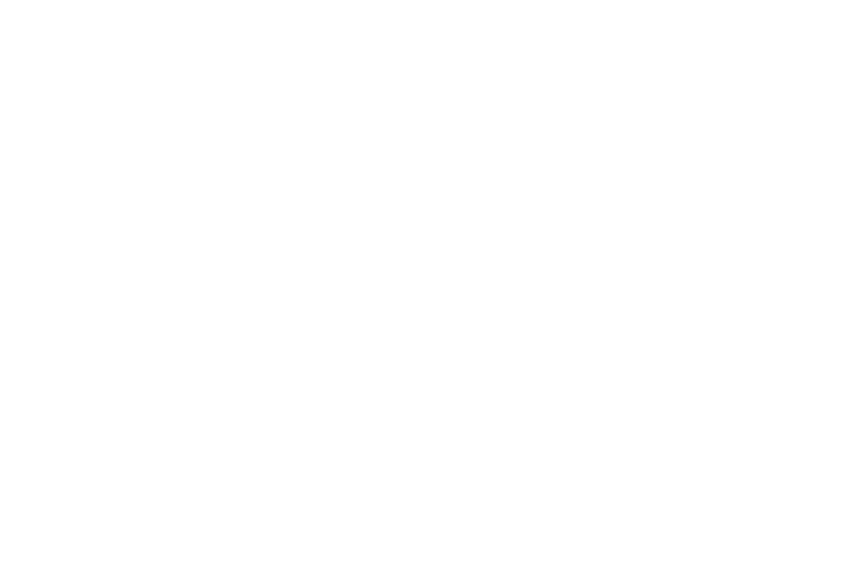

In [10]:
# split = int(len(x_train)*0.8)
# x_train, x_val = x_train[:split], x_train[split:]
# y_train, y_val = y_train[:split], y_train[split:]

x_train = np.concatenate([x_train, x_test], axis=0)
y_train = np.concatenate([y_train, y_test], axis=0)

# plt.scatter(x_test[:,0], x_test[:,1], c=y_test)
g = plot(x_train, y_train)

In [11]:
n_clusters = latent_dim

bsize = 512

batch_sizes = {
    'Unlabeled': bsize,
    'Labeled': bsize,
    'Orthonorm': bsize,
    }

input_shape = x_train.shape[1:]
y_true = tf.placeholder(tf.float32, shape=(None, n_clusters), name='y_true')
y_train_labeled_onehot = np.empty((0, len(np.unique(y_train))))
inputs = {
    'Unlabeled': Input(shape=input_shape,name='UnlabeledInput'),
    'Labeled': Input(shape=input_shape,name='LabeledInput'),
    'Orthonorm': Input(shape=input_shape,name='OrthonormInput'),
    }
k = 3
spectral_net = SpectralNet(inputs, arch,
            None, y_true, y_train_labeled_onehot,
            n_clusters, affinity='full', scale_nbr=k, n_nbrs=k, 
            batch_sizes=batch_sizes, siamese_net=None, 
            x_train=x_train, have_labeled=len(x_train))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [12]:
spectral_net.train(
        x_train, np.zeros_like(x_train[0:0]), x_test,
        lr=5e-5, drop=0.1, patience=30, num_epochs=100)

Epoch: 0, loss=0.409462, val_loss=0.000383
Epoch: 1, loss=0.115589, val_loss=0.000034
Epoch: 2, loss=0.027877, val_loss=0.000015
Epoch: 3, loss=0.014190, val_loss=0.000011
Epoch: 4, loss=0.012531, val_loss=0.000011
Epoch: 5, loss=0.012381, val_loss=0.000012
Epoch: 6, loss=0.012295, val_loss=0.000011
Epoch: 7, loss=0.012217, val_loss=0.000012
Epoch: 8, loss=0.012183, val_loss=0.000011
Epoch: 9, loss=0.012077, val_loss=0.000010
Epoch: 10, loss=0.012185, val_loss=0.000011
Epoch: 11, loss=0.012078, val_loss=0.000011
Epoch: 12, loss=0.012096, val_loss=0.000010
Epoch: 13, loss=0.012067, val_loss=0.000011
Epoch: 14, loss=0.011935, val_loss=0.000011
Epoch: 15, loss=0.011964, val_loss=0.000011
Epoch: 16, loss=0.011969, val_loss=0.000010
Epoch: 17, loss=0.011892, val_loss=0.000011
Epoch: 18, loss=0.011885, val_loss=0.000011
Epoch: 19, loss=0.011996, val_loss=0.000012
Epoch: 20, loss=0.011955, val_loss=0.000011
Epoch: 21, loss=0.011911, val_loss=0.000011
Epoch: 22, loss=0.011965, val_loss=0.00001

(array([0.40946167, 0.11558896, 0.02787706, 0.01419019, 0.01253095,
        0.01238112, 0.01229469, 0.0122173 , 0.01218285, 0.01207724,
        0.01218467, 0.01207776, 0.01209564, 0.01206728, 0.01193467,
        0.01196396, 0.01196864, 0.01189223, 0.01188485, 0.01199566,
        0.0119549 , 0.01191083, 0.01196496, 0.01188039, 0.01200094,
        0.01188951, 0.0119349 , 0.0118701 , 0.01189948, 0.01194077,
        0.01194114, 0.01186938, 0.01184515, 0.01197221, 0.01188841,
        0.01178982, 0.01180435, 0.01194359, 0.0118604 , 0.01178441,
        0.0119084 , 0.01177692, 0.01167423, 0.01169441, 0.01171946,
        0.01174904, 0.011668  , 0.01178503, 0.01158405, 0.0116626 ,
        0.01168569, 0.01165873, 0.01175379, 0.01175638, 0.01168773,
        0.01168384, 0.01163547, 0.01170329, 0.01158526, 0.01159902,
        0.01162683, 0.01173652, 0.01172163, 0.01166652, 0.0117705 ,
        0.01174711, 0.01174087, 0.01172888, 0.01163864, 0.01171777,
        0.01160664, 0.01165345, 0.01162418, 0.01

<IPython.core.display.Javascript object>


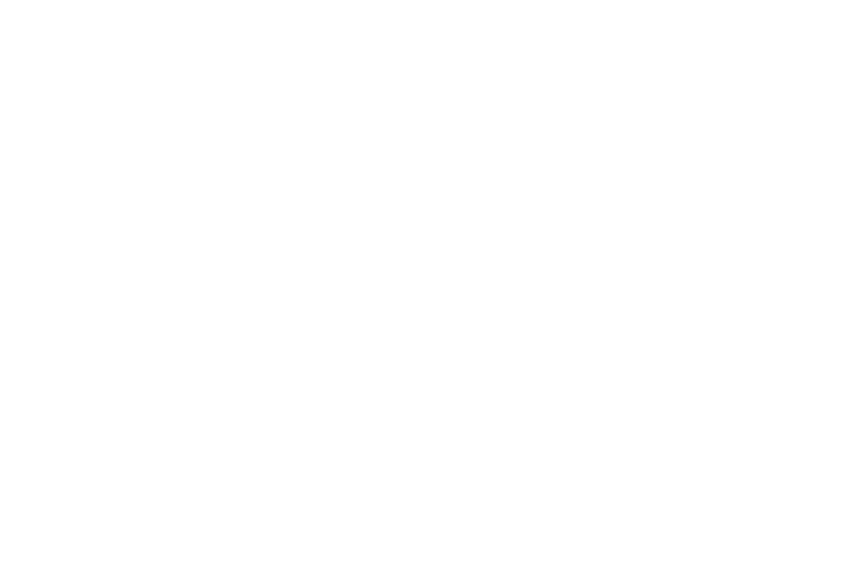

range of y_pred values: 1.631641149520874 - -1.5056853294372559


In [13]:
y_pred = spectral_net.predict(x_test)
g = plot(y_pred[:,:3], y_test)
print('range of y_pred values: {} - {}'.format(np.max(y_pred), np.min(y_pred)))

<IPython.core.display.Javascript object>


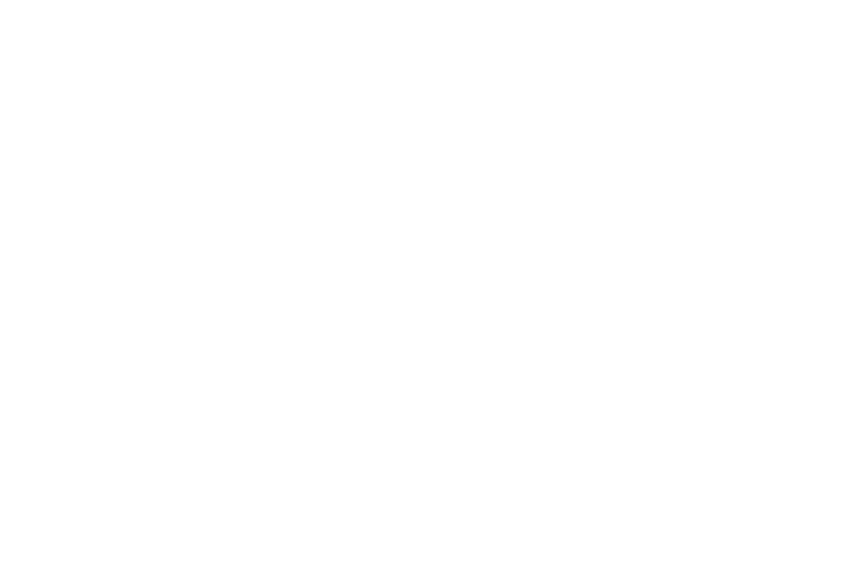

In [14]:
# now plot all the dimensions of spectralnet
y_pred_embedded = TSNE().fit_transform(y_pred)
g = plot(y_pred_embedded[:,:2], y=y_test)

In [51]:
svg = SVG(inputs, spectralnet=spectral_net, orig_dim=x_train.shape[-1], latent_dim=latent_dim)

In [52]:
svg.train_gan(x_train, epochs=50, n_critic=10, n_vae=50)

0 [D loss: 0] [G loss: 0] [VAE loss: 18.874835968017578]
1 [D loss: 0] [G loss: 0] [VAE loss: 15.881157875061035]
2 [D loss: 0] [G loss: 0] [VAE loss: 15.701025009155273]
3 [D loss: 0] [G loss: 0] [VAE loss: 16.04654884338379]
4 [D loss: 0] [G loss: 0] [VAE loss: 15.238402366638184]
5 [D loss: 0] [G loss: 0] [VAE loss: 15.19039249420166]
6 [D loss: 0] [G loss: 0] [VAE loss: 15.127181053161621]
7 [D loss: 0] [G loss: 0] [VAE loss: 14.665250778198242]
8 [D loss: 0] [G loss: 0] [VAE loss: 14.041497230529785]
9 [D loss: 0] [G loss: 0] [VAE loss: 13.98896598815918]
10 [D loss: 0] [G loss: 0] [VAE loss: 13.741212844848633]
11 [D loss: 0] [G loss: 0] [VAE loss: 13.916378021240234]
12 [D loss: 0] [G loss: 0] [VAE loss: 14.998239517211914]
13 [D loss: 0] [G loss: 0] [VAE loss: 13.805285453796387]
14 [D loss: 0] [G loss: 0] [VAE loss: 14.407218933105469]
15 [D loss: 0] [G loss: 0] [VAE loss: 13.793588638305664]
16 [D loss: 0] [G loss: 0] [VAE loss: 14.2467622756958]
17 [D loss: 0] [G loss: 0] [V

In [53]:
%matplotlib

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


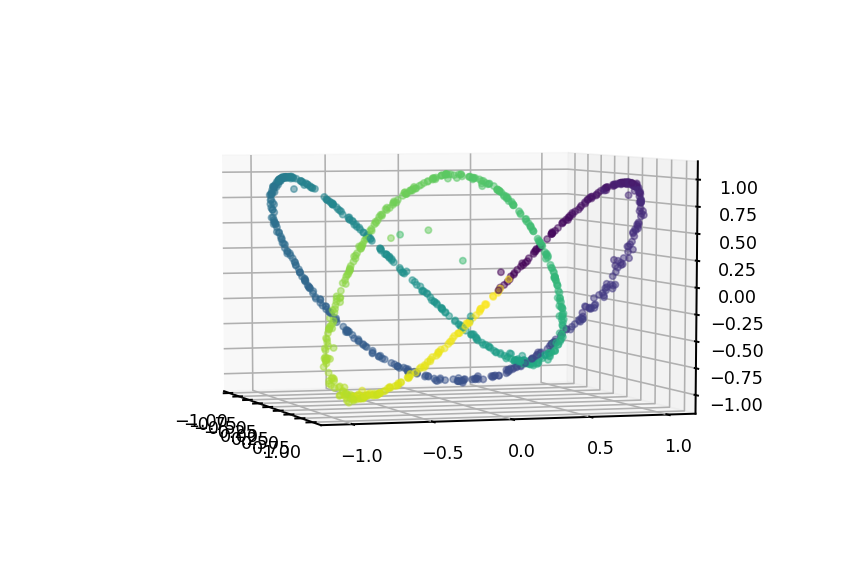

In [54]:
x_gen = svg.generate_from_samples(x_train)
g = plot(x_gen, y_train)

<IPython.core.display.Javascript object>


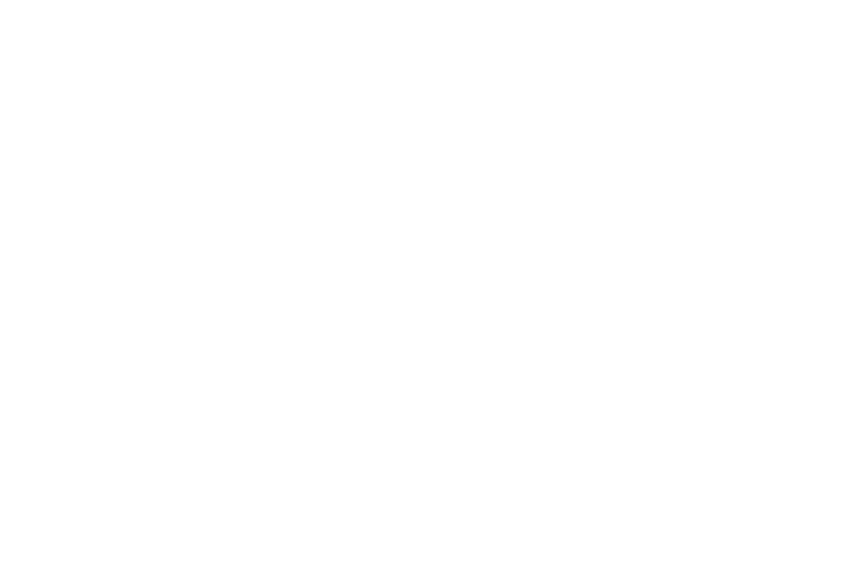

In [19]:
n_samples = 100
n_items = 1
x_gen = np.zeros((n_samples*n_items, x_train.shape[1]))
y_gen = np.zeros((n_samples*n_items,))
step = int(len(x_test) / n_items)
for i in range(n_samples):
    for n in range(n_items):
#         print(n_items*i + n, n*step, step)
        x_gen[n_items*i + n,:] = x_test[n*step,:]
        y_gen[n_items*i + n] = y_test[n*step]
    
x_gen = svg.generate_from_samples(x_gen)
g = plot(x_gen[:, :3], y_gen)

<IPython.core.display.Javascript object>


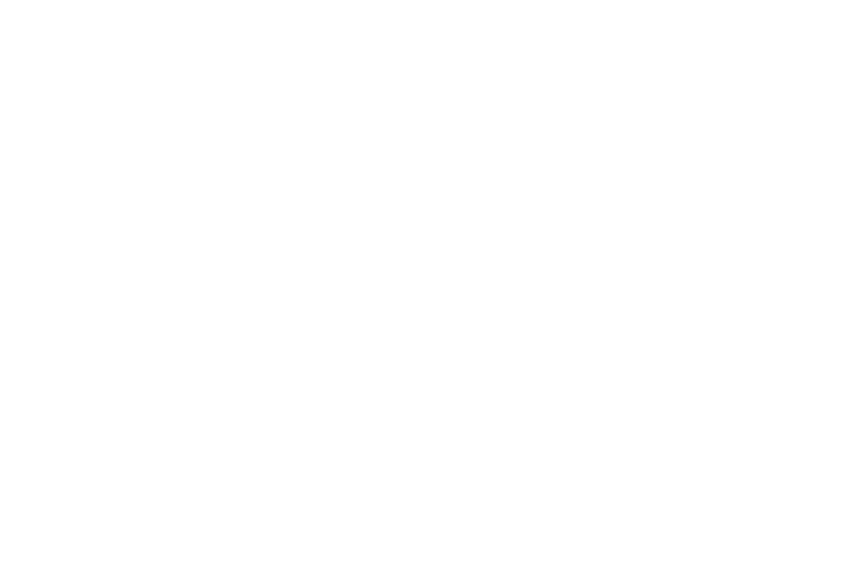

In [20]:
x = svg.generate_from_samples(x_test)
if dataset == 'mnist':
    n_imgs = 10
    # num = 7
    # sub = y_test == num
    sub = y_test == y_test
    for i in range(n_imgs):
        idx = np.random.randint(len(x[sub]))
        plt.subplot(1,2,1)
        plt.imshow(x_test[sub][idx].reshape(28, 28))
        plt.subplot(1,2,2)
        plt.imshow(x[sub][idx].reshape(28, 28))
        plt.figure()
else:
    x = svg.generate_from_samples(x_test)
    plot(x, y_test)

In [55]:
# get number of neighbors within one standard deviation of each element in x_test
_, _mu, _sigma_v, _sigma_lam = svg.generate_from_samples(x_test, return_mu_sigma=True)
_sigma_v = _sigma_v.reshape(-1, latent_dim, latent_dim)

num_close = []
for i in range(len(_mu)):
    l, v, m = np.exp(0.5 * -_sigma_lam[i,:]), _sigma_v[i,:], _mu[i,:]
    left_cov = np.einsum('ij,j->ij', v, l)
    cov = np.einsum('ij,kj->ik', left_cov, v)
    scaled_dists = np.einsum('jk,ik->ij', cov, _mu - m)
    # consider as neighbors all points within the variance of x_i
    less_than_std = np.abs(scaled_dists) < 1
    less_than_std = np.logical_and(less_than_std[:,0], less_than_std[:,1])
    # split neighbors into those of the same class and those of a different class
    same, diff = (y_test[less_than_std] == y_test[i]), (y_test[less_than_std] != y_test[i])
    num_close.append((np.sum(same), np.sum(diff)))

<IPython.core.display.Javascript object>


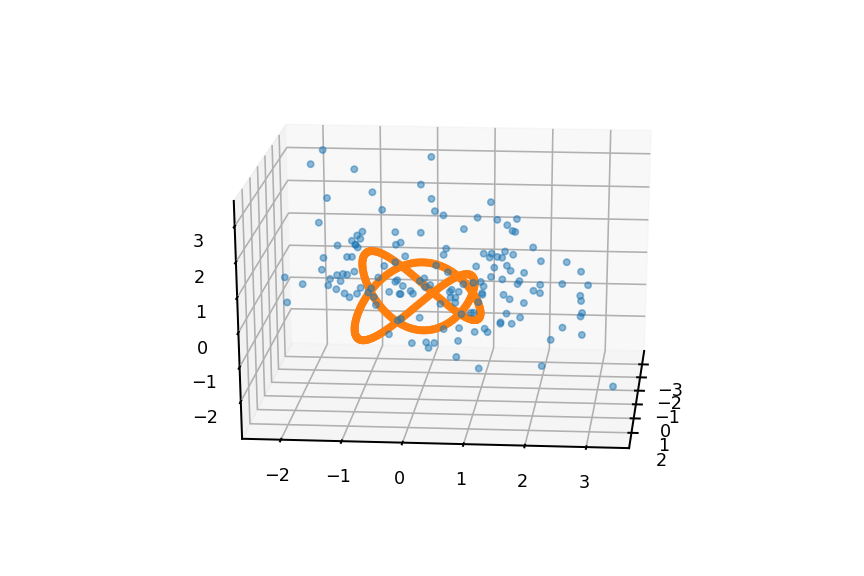

In [57]:
_sigma = np.einsum('ijk,ilk->ijl', np.einsum('ijk,ik->ijk', _sigma_v, np.exp(0.5 * _sigma_lam)), _sigma_v)
perturbed_x = _mu + np.einsum('ijk,ik->ij', _sigma, np.random.normal(size=_mu.shape))
g = plot(perturbed_x, x2=x_train)

In [ ]:
# differentiate decoder with respect to inputs to compute another jacobian, and then evaluate it on the same point
_jacobian = [tf.expand_dims(tf.gradients(svg.x_recon[:,i], svg.x_enc)[0], 1) for i in range(svg.x_recon.shape[1])]
jacobian = tf.reduce_sum(tf.concat(_jacobian, axis=1), axis=0)
B = tf.einsum('ijk,ilk->ijl', tf.einsum('ijk,ik->ijk', svg.z_cov_vectors, np.exp(0.5 * svg.z_log_cov_values)), svg.z_cov_vectors)
B = tf.reduce_mean(B, axis=0)
cov = tf.matmul(jacobian, tf.matmul(B, jacobian, transpose_b=True))
cov = tf.reshape(cov, (x_test[0].shape[0], x_test[0].shape[0]))

In [ ]:
# create burst from a point and compute covariance matrix
burst_size = 1000
rand_idx = np.random.randint(len(x_test))
x_ = x_test[rand_idx]
# x_ = np.array((np.cos(.25), np.sin(.25)))
x_arr = np.array([x_] * burst_size)
x_rec = svg.generate_from_samples(x_arr)

cov_burst = np.cov((x_rec - np.mean(x_rec, axis=0)).T)

# run gradient burst"
# cov_grad = K.get_session().run([svg.x_recon, cov, B, jacobian], feed_dict={svg.input: np.array([x_]*1)})
cov_grad = K.get_session().run([cov], feed_dict={svg.input: np.array([x_]*1)})[0]

In [ ]:
cov_burst

In [ ]:
cov_grad

In [ ]:
l_burst, _ = np.linalg.eig(cov_burst)
l_grad, _ = np.linalg.eig(cov_grad)
print('l_burst:', l_burst, l_burst/l_burst[0])
print('l_grad:', l_grad, l_grad/l_grad[0])

In [ ]:
g = plot(x_rec, x2=x_test, label1='true', label2='predicted')

In [ ]:
x__ = np.expand_dims(x_, axis=0)
g = plot(x__, x2=x_test, alpha=.1, label1='true', label2='predicted')

In [ ]:
g = plot(x_test)

In [ ]:
# RANDOM WALK
def walk(f, x_arr, branch_factor=5, n_steps=20, max_size=1000):
    p = np.random.permutation(len(x_arr))[:1000]
    x_arr = x_arr[p]
    for i in range(n_steps):
        x_arr = np.array([x_arr] * branch_factor).reshape([-1, x_.shape[0]])
        (x_arr, x_mu, x_sigma) = f(x_arr)
        p = np.random.permutation(len(x_arr))[:1000]
        x_arr, x_mu, x_sigma = x_arr[p], x_mu[p], x_sigma[p]
        
    return x_arr, x_mu, x_sigma

In [49]:
f = partial(svg.generate_from_samples, return_mu_sigma=True, normalize_cov=True)
y_test_sz = np.mean(f(x_all)[3], axis=1)
sz_max = np.max(y_test_sz)
sz_min = np.min(y_test_sz)
y_test_sz = (y_test_sz - sz_min)/(sz_max - sz_min) * 5
print(np.min(y_test_sz), np.max(y_test_sz))
y_test_sz = np.exp(0.5 * y_test_sz)

(1000, 3)
0.0 5.0


<IPython.core.display.Javascript object>


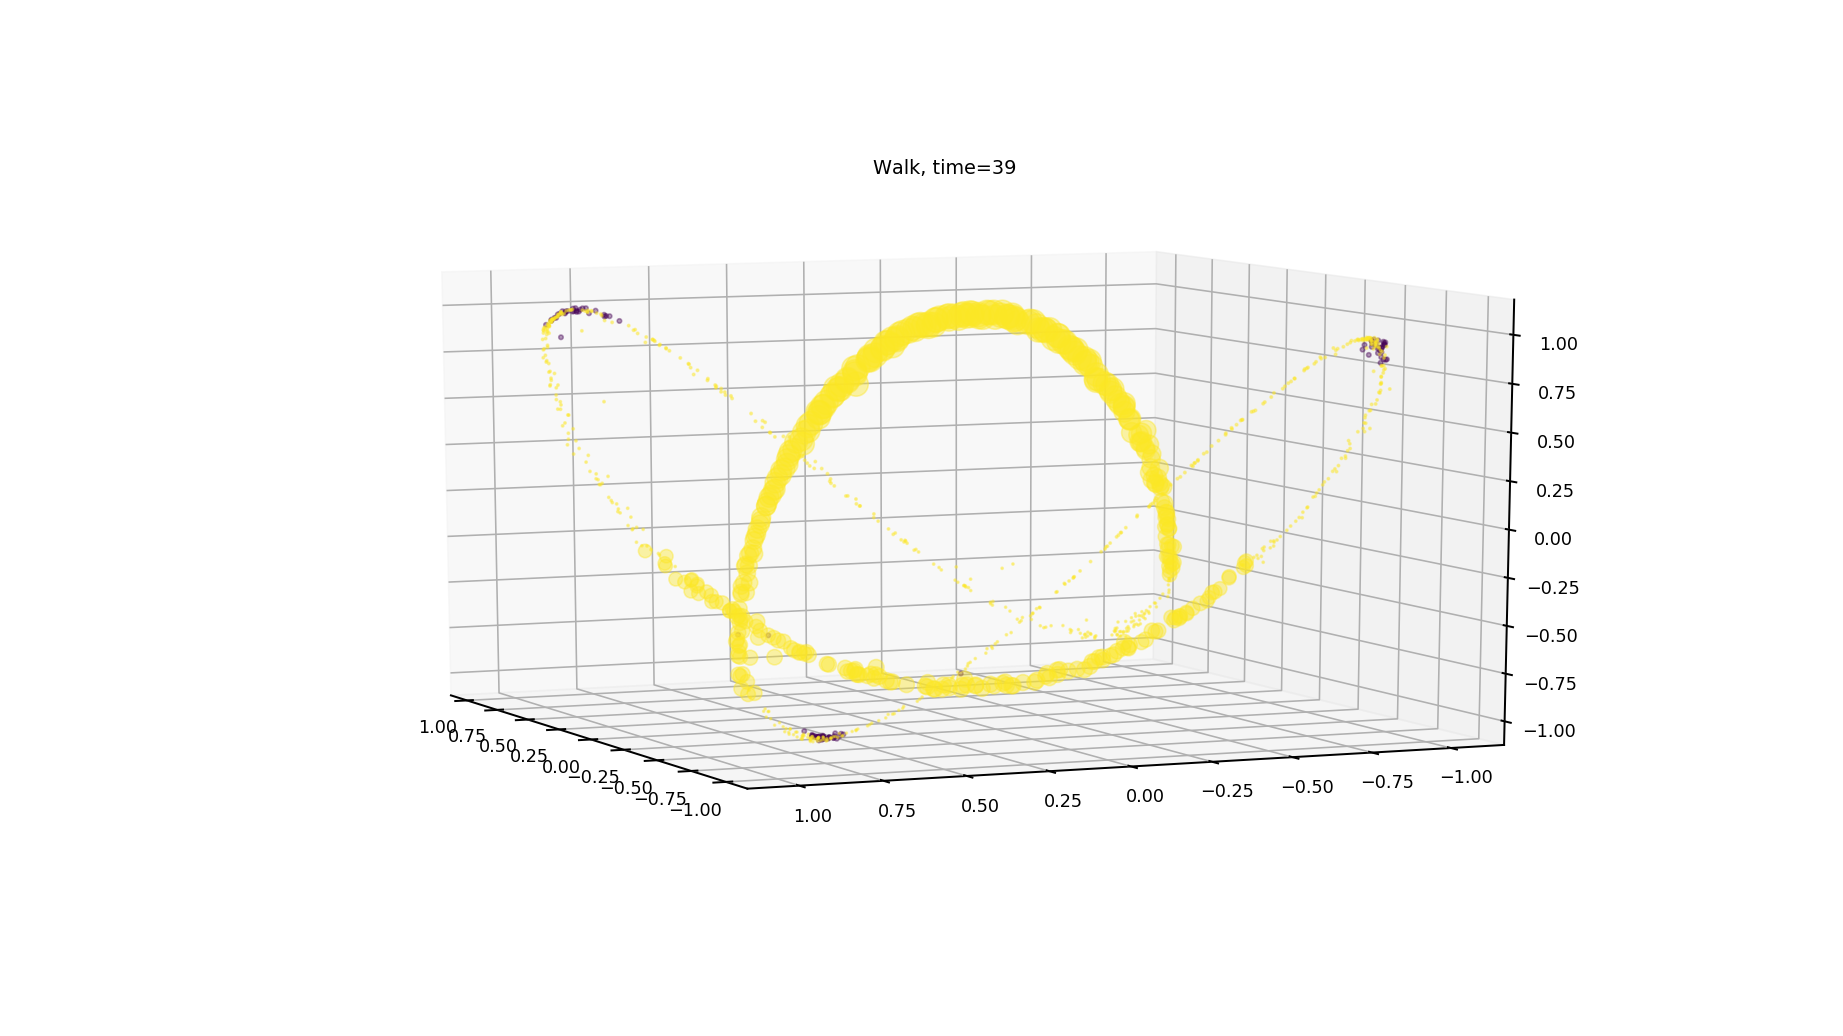

In [26]:
import matplotlib.animation

# which space do we want to plot in?
plot_latent = False
plot_idx = 1 if plot_latent else 0

x_arr = np.random.permutation(x_test)[:100]
x__ = f(x_all)[plot_idx]
x_ = f(x_arr)[plot_idx]
x_tot = np.concatenate([x_, x__], axis=0)
y_tot = np.concatenate([np.zeros(shape=(len(x_arr),)), np.ones(shape=(len(x__),))*2], axis=0)
y_sz = np.concatenate([np.ones(shape=(len(x_arr),))*5, y_test_sz], axis=0)

def update_graph(num):
    global x_arr
    global x__
    global y_tot
    x_arr, x_mu, x_sigma_v, x_sigma_lam = f(x_arr)
    # plot in latent or original space
    x_ = x_mu if plot_latent else x_arr
    
    x_ = np.concatenate([x_, x__], axis=0)
    graph._offsets3d = (x_[:,0], x_[:,1], x_[:,2])
    ax.view_init(elev=10, azim=num*4)
    title.set_text('Walk, time={}'.format(num))

fig = plt.figure(figsize=(12.8, 7.2))
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Walk, time=0')

graph = ax.scatter(x_tot[:,0], x_tot[:,1], x_tot[:,2], c=y_tot, s=y_sz, alpha=0.4)

ani = matplotlib.animation.FuncAnimation(fig, update_graph, 90, 
                               interval=100, blit=False)

In [ ]:
from IPython.display import HTML
HTML(ani.to_html5_video(embed_limit=None))

In [ ]:
f = partial(svg.generate_from_samples, return_mu_sigma=True)

x_test_sample = np.random.permutation(x_test)[:10]
x_arr, x_sigma, x_mu = walk(f, x_test_sample)

In [ ]:
g = plot(x_arr, x2=x_test, label1='predicted', label2='true')

In [ ]:
# g = plot(x_mu, x2=f(x_test_sample)[1])
g = plot(x_mu, x2=f(x_test)[1])

In [ ]:
g = plot(x_arr)

In [ ]:
print("samar was here")